In [1]:
import torch
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

sys.path.append('..')
from src.embedding.gym_dataset import AbstractActionsData
from src.embedding.gym_dataset import GymData
from src.embedding.gym_dataset import load_or_generate

%load_ext autoreload
%autoreload 2

import wandb

wandb.init(project='dyne-visualise', entity='vinnibuh')

In [2]:
encoder_4 = torch.load('../models/encoder/dmc_hopper_hop/DynE-4-new/encoder.pt')
encoder_6 = torch.load('../models/encoder/dmc_hopper_hop/DynE-6-new/encoder.pt')
encoder_8 = torch.load('../models/encoder/dmc_hopper_hop/DynE-8-new/encoder.pt')

data_4 = AbstractActionsData('dmc_hopper_hop', 4, encoder_4)
data_6 = AbstractActionsData('dmc_hopper_hop', 6, encoder_6)
data_8 = AbstractActionsData('dmc_hopper_hop', 8, encoder_8)

In [3]:
gym_data_4 = torch.load('../datasets/torch/dmc_hopper_hop_len4_n100000_qposFalse_qvelFalse_deltaTrue_whitenTrue_pixelsFalse.pt')
data_4.mean, data_4.std = gym_data_4.mean, gym_data_4.std

gym_data_6 = torch.load('../datasets/torch/dmc_hopper_hop_len6_n100000_qposFalse_qvelFalse_deltaTrue_whitenTrue_pixelsFalse.pt')
data_6.mean, data_6.std = gym_data_6.mean, gym_data_6.std

gym_data_8 = torch.load('../datasets/torch/dmc_hopper_hop_len8_n100000_qposFalse_qvelFalse_deltaTrue_whitenTrue_pixelsFalse.pt')
data_8.mean, data_8.std = gym_data_8.mean, gym_data_8.std

del gym_data_4
del gym_data_6
del gym_data_8

In [4]:
data_4.load_from_directory('../datasets/dreamer/dreamer_finetuned/episodes')
data_6.load_from_directory('../datasets/dreamer/dreamer_finetuned/episodes')
data_8.load_from_directory('../datasets/dreamer/dreamer_finetuned/episodes')

In [5]:
data = {}
data[4] = data_4
data[6] = data_6
data[8] = data_8

In [18]:
num_samples = len(data[4])
mu_sample = {k: data[k].transform_episode(0) for k in data.keys()}

episode_len = {k: mu_sample[k][0].size(0) for k in mu_sample.keys()}
mu_dim = {k: mu_sample[k][0].size(1) for k in mu_sample.keys()}

mu_i = {k: np.zeros([num_samples, episode_len[k], mu_dim[k]]) for k in data.keys()}
for k in data.keys():
    for i in range(num_samples):
        mu_i[k][i], _, _ = data[k].transform_episode(i)

Text(0.5, 1.0, 'Mean Mu, DynE-8')

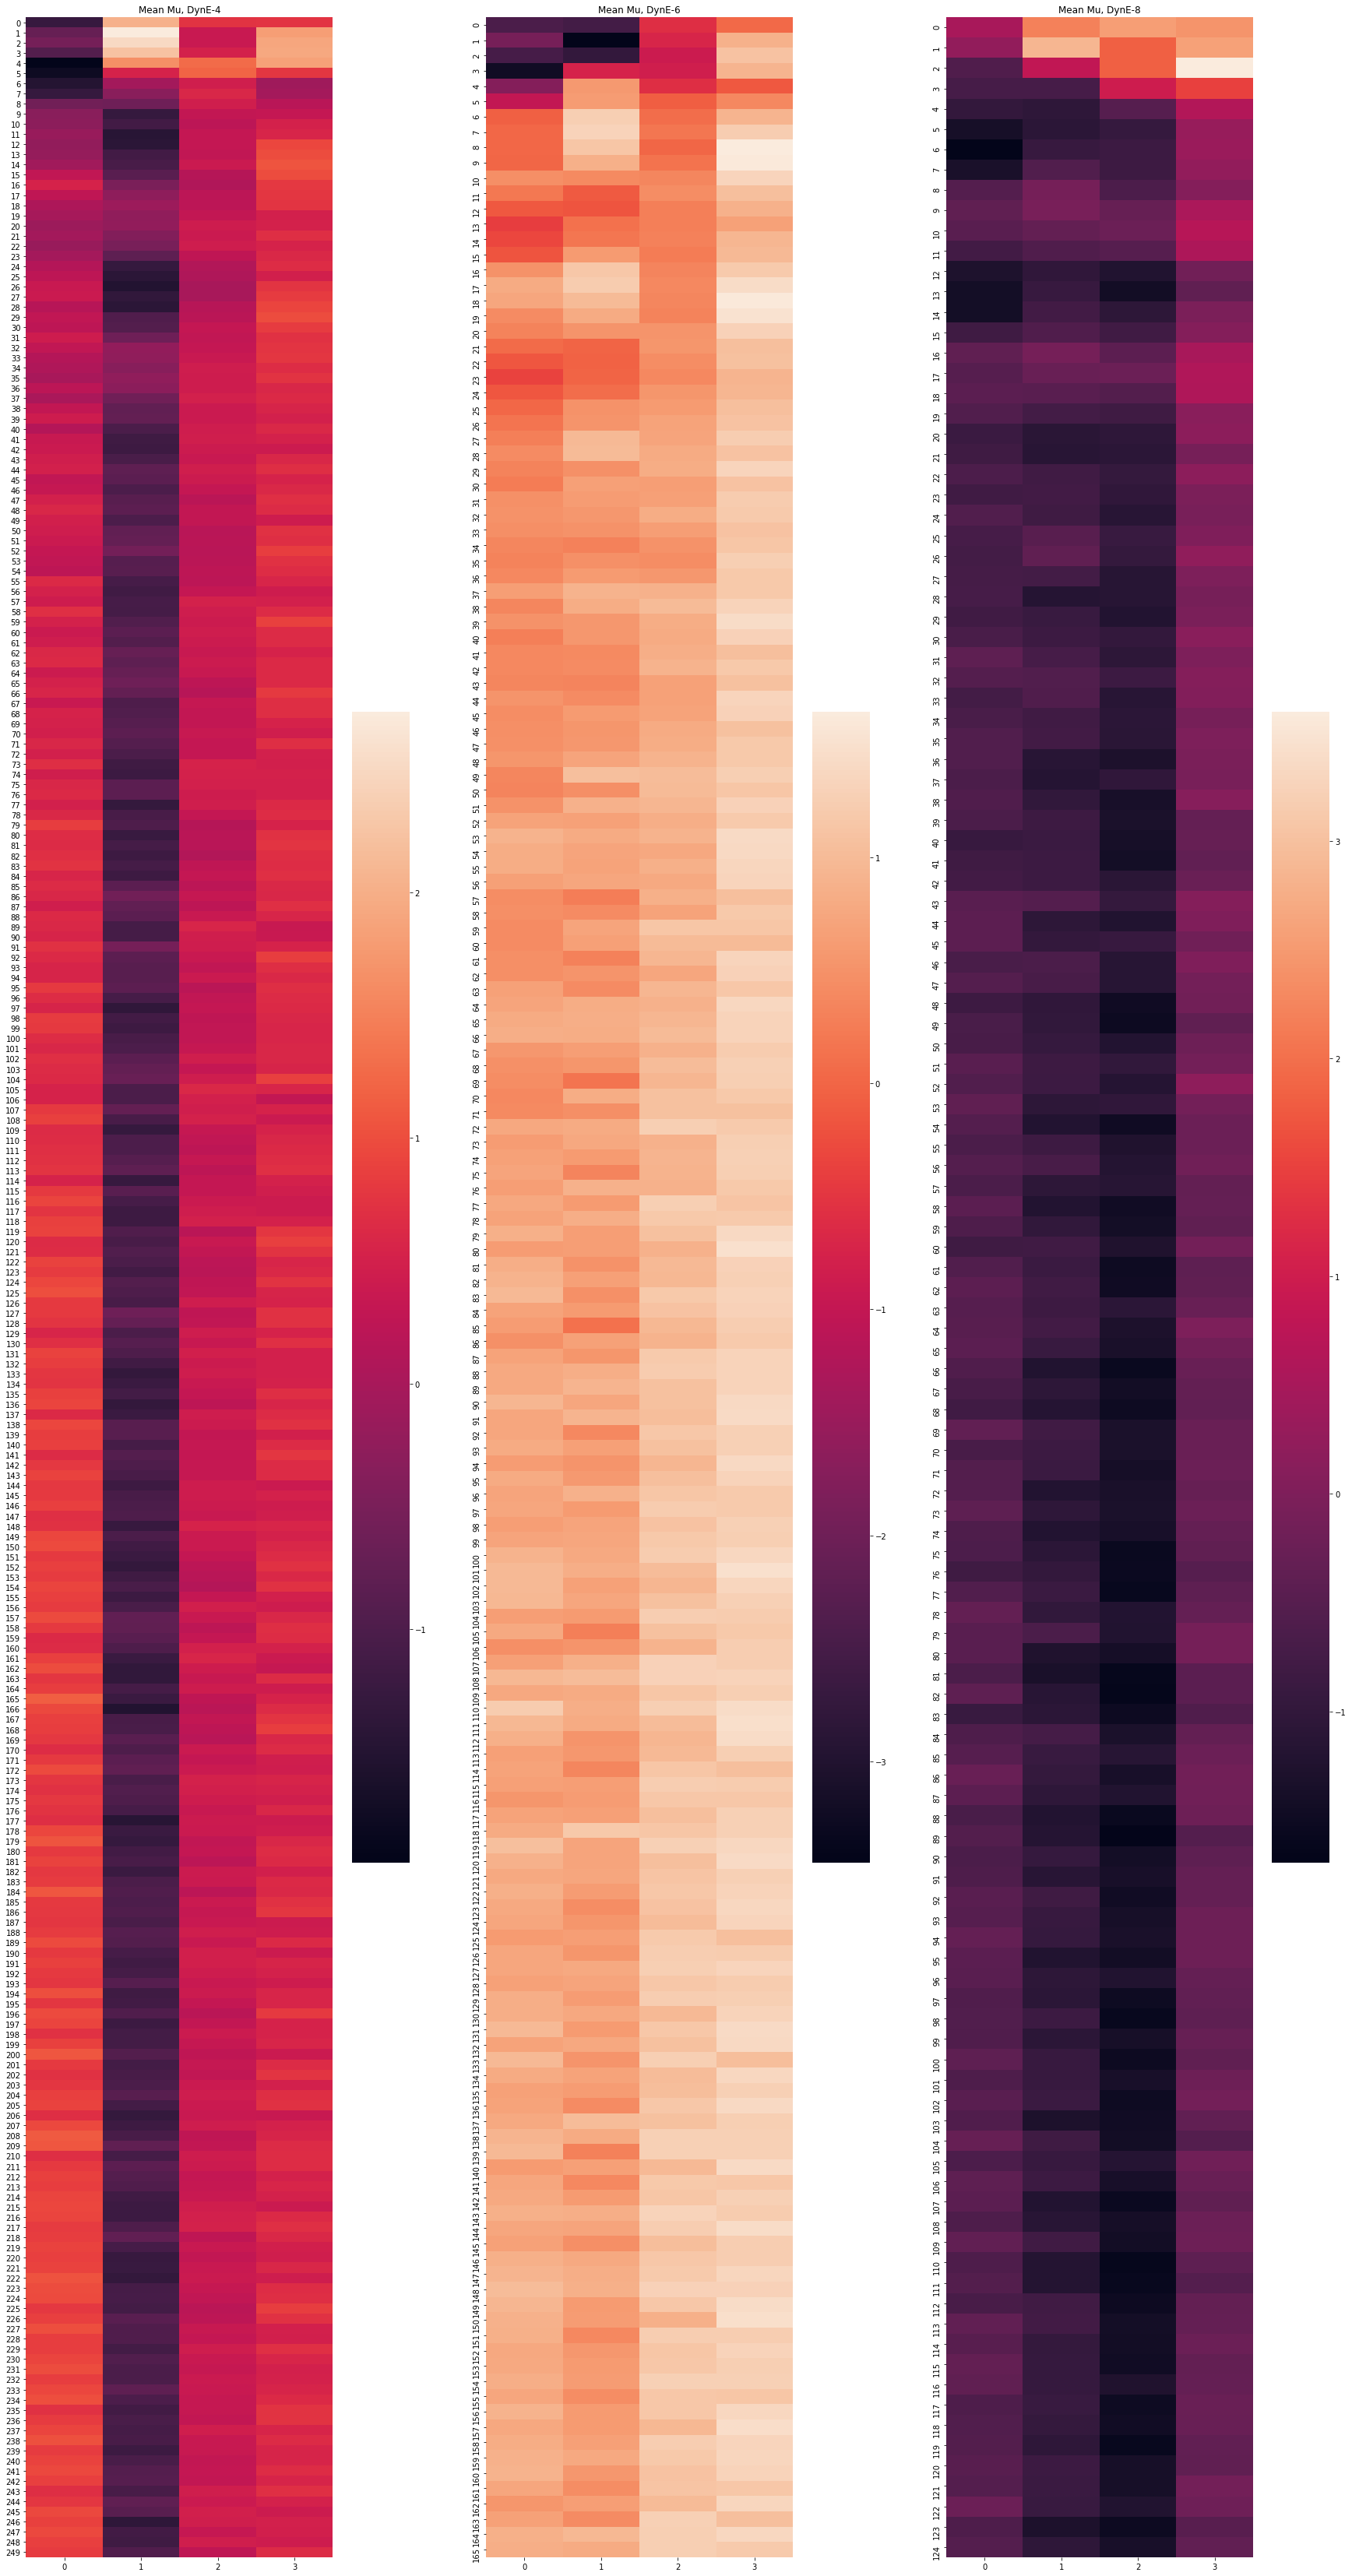

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 60), sharey=False)

x = sns.heatmap(mu_i[4].mean(axis=0), ax=ax1)
ax1.set_title('Mean Mu, DynE-4')
y = sns.heatmap(mu_i[6].mean(axis=0), ax=ax2)
ax2.set_title('Mean Mu, DynE-6')
x = sns.heatmap(mu_i[8].mean(axis=0), ax=ax3)
ax3.set_title('Mean Mu, DynE-8')

In [23]:
decoders = {k : torch.load('../models/decoder/dmc_hopper_hop/DynE-{}/decoder.pt'.format(k)) for k in data.keys()}

In [29]:
decoded_action = {k: decoders[k](torch.from_numpy(mu_i[k][0]).float()) for k in data.keys()}
episode_len = {k: decoded_action[k].size(0) for k in decoded_action.keys()}
traj_len = {k: decoded_action[k].size(1) for k in decoded_action.keys()}
action_size = {k: decoded_action[k].size(2) for k in decoded_action.keys()}

dec_actions = {k: np.zeros([len(data[k]), episode_len[k] * traj_len[k], action_size[k]]) for k in data.keys()}
actions = {k: np.zeros([len(data[k]), episode_len[k] * traj_len[k], action_size[k]]) for k in data.keys()}
with torch.no_grad():
    for k in data.keys():
        z_mean = decoders[k].mean_z
        z_std = decoders[k].std_z
        for i in range(len(mu_i[k])):
            z = torch.from_numpy(mu_i[k][i]).float()
            z_whitened = (z - z_mean) / z_std
            dec_actions[k][i] = decoders[k](z_whitened).reshape([episode_len[k] * traj_len[k], action_size[k]])
            actions[k][i] = np.repeat(data[k][i][1][1:], 2, axis=0)[:episode_len[k] * traj_len[k]]

Text(0.5, 1.0, 'Decoder/orig mean actions diff, DynE-8')

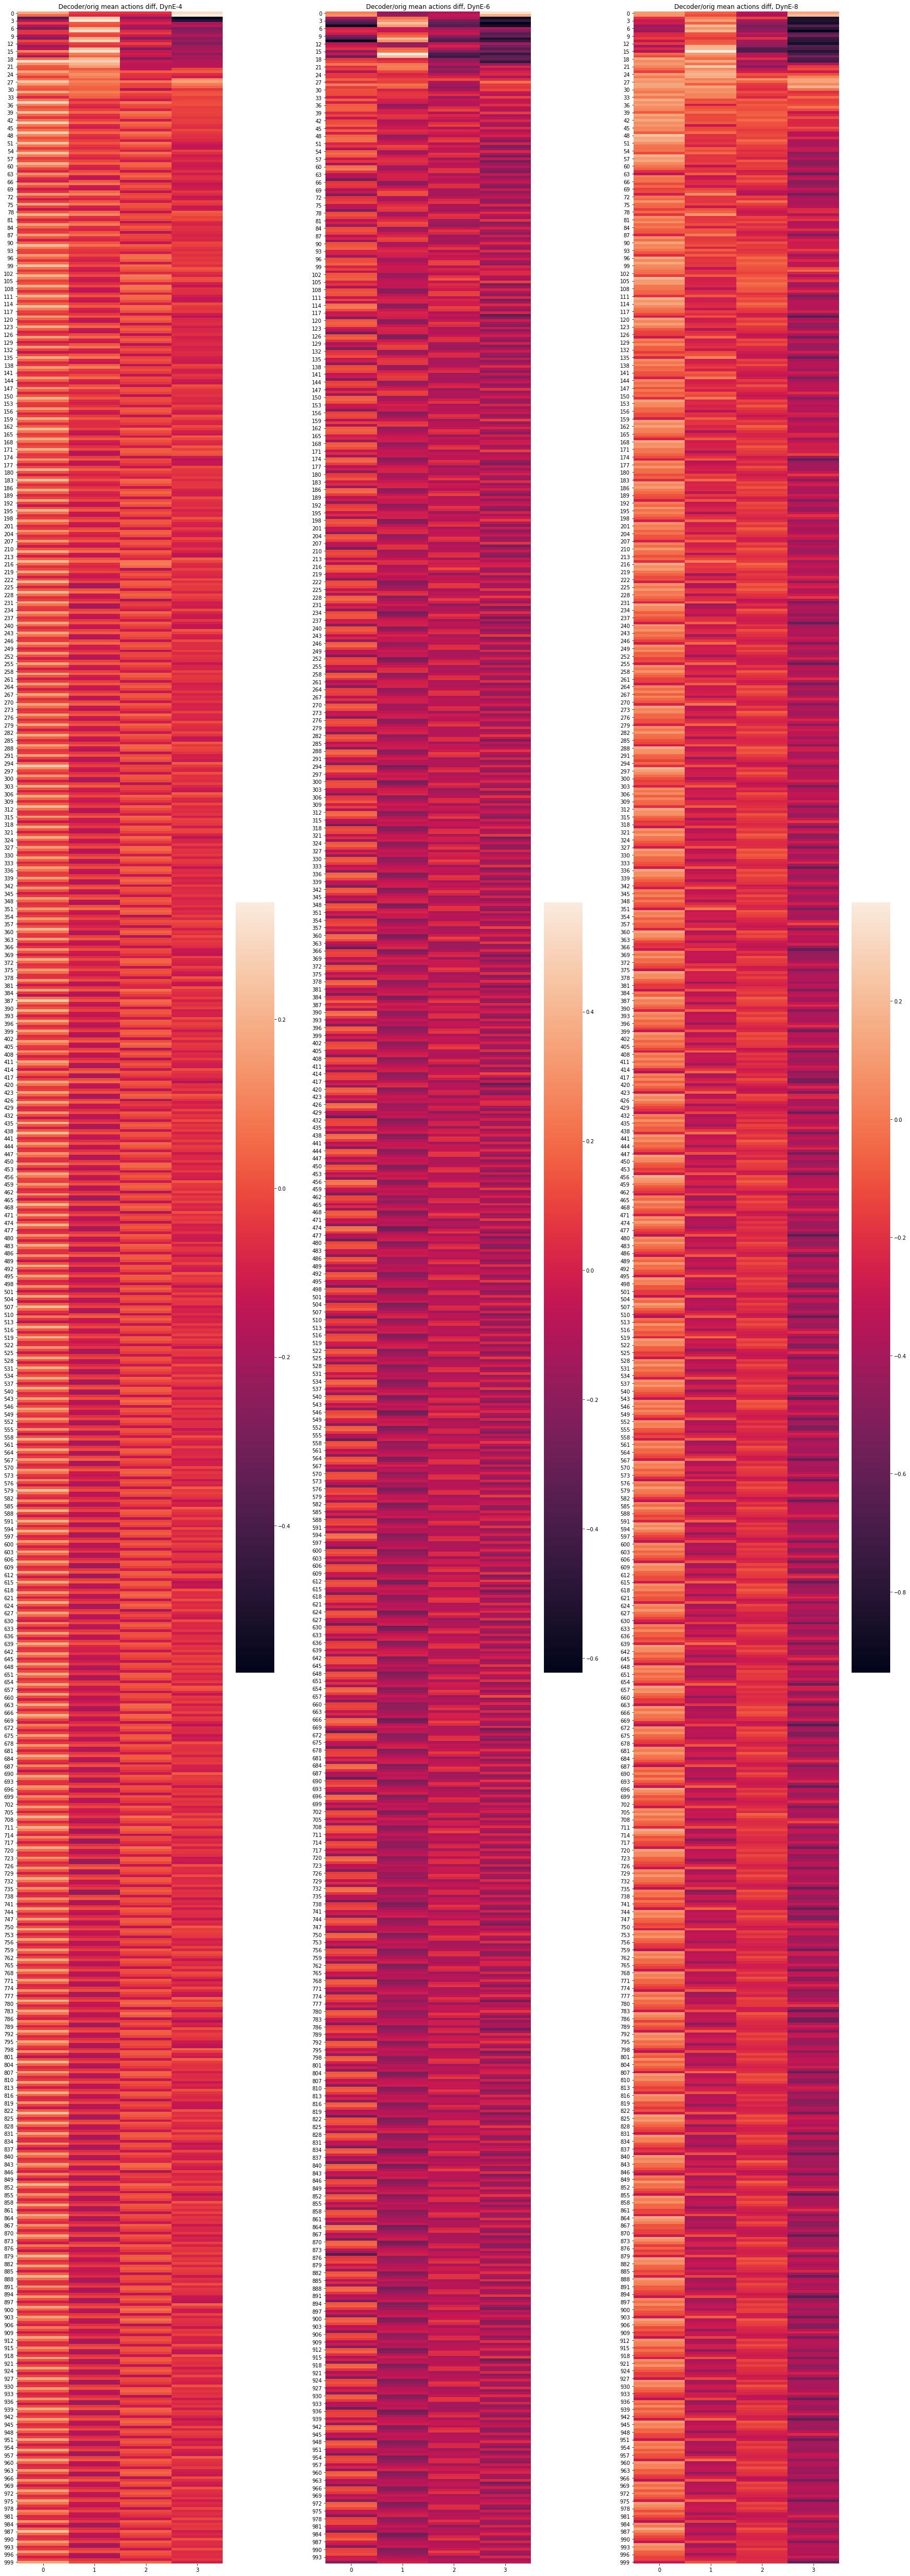

In [34]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 90))

x = sns.heatmap((dec_actions[4]-actions[4]).mean(0), ax=ax1)
ax1.set_title('Decoder/orig mean actions diff, DynE-4')

y = sns.heatmap((dec_actions[6]-actions[6]).mean(0), ax=ax2)
ax2.set_title('Decoder/orig mean actions diff, DynE-6')

z = sns.heatmap((dec_actions[8]-actions[8]).mean(0), ax=ax3)
ax3.set_title('Decoder/orig mean actions diff, DynE-8')

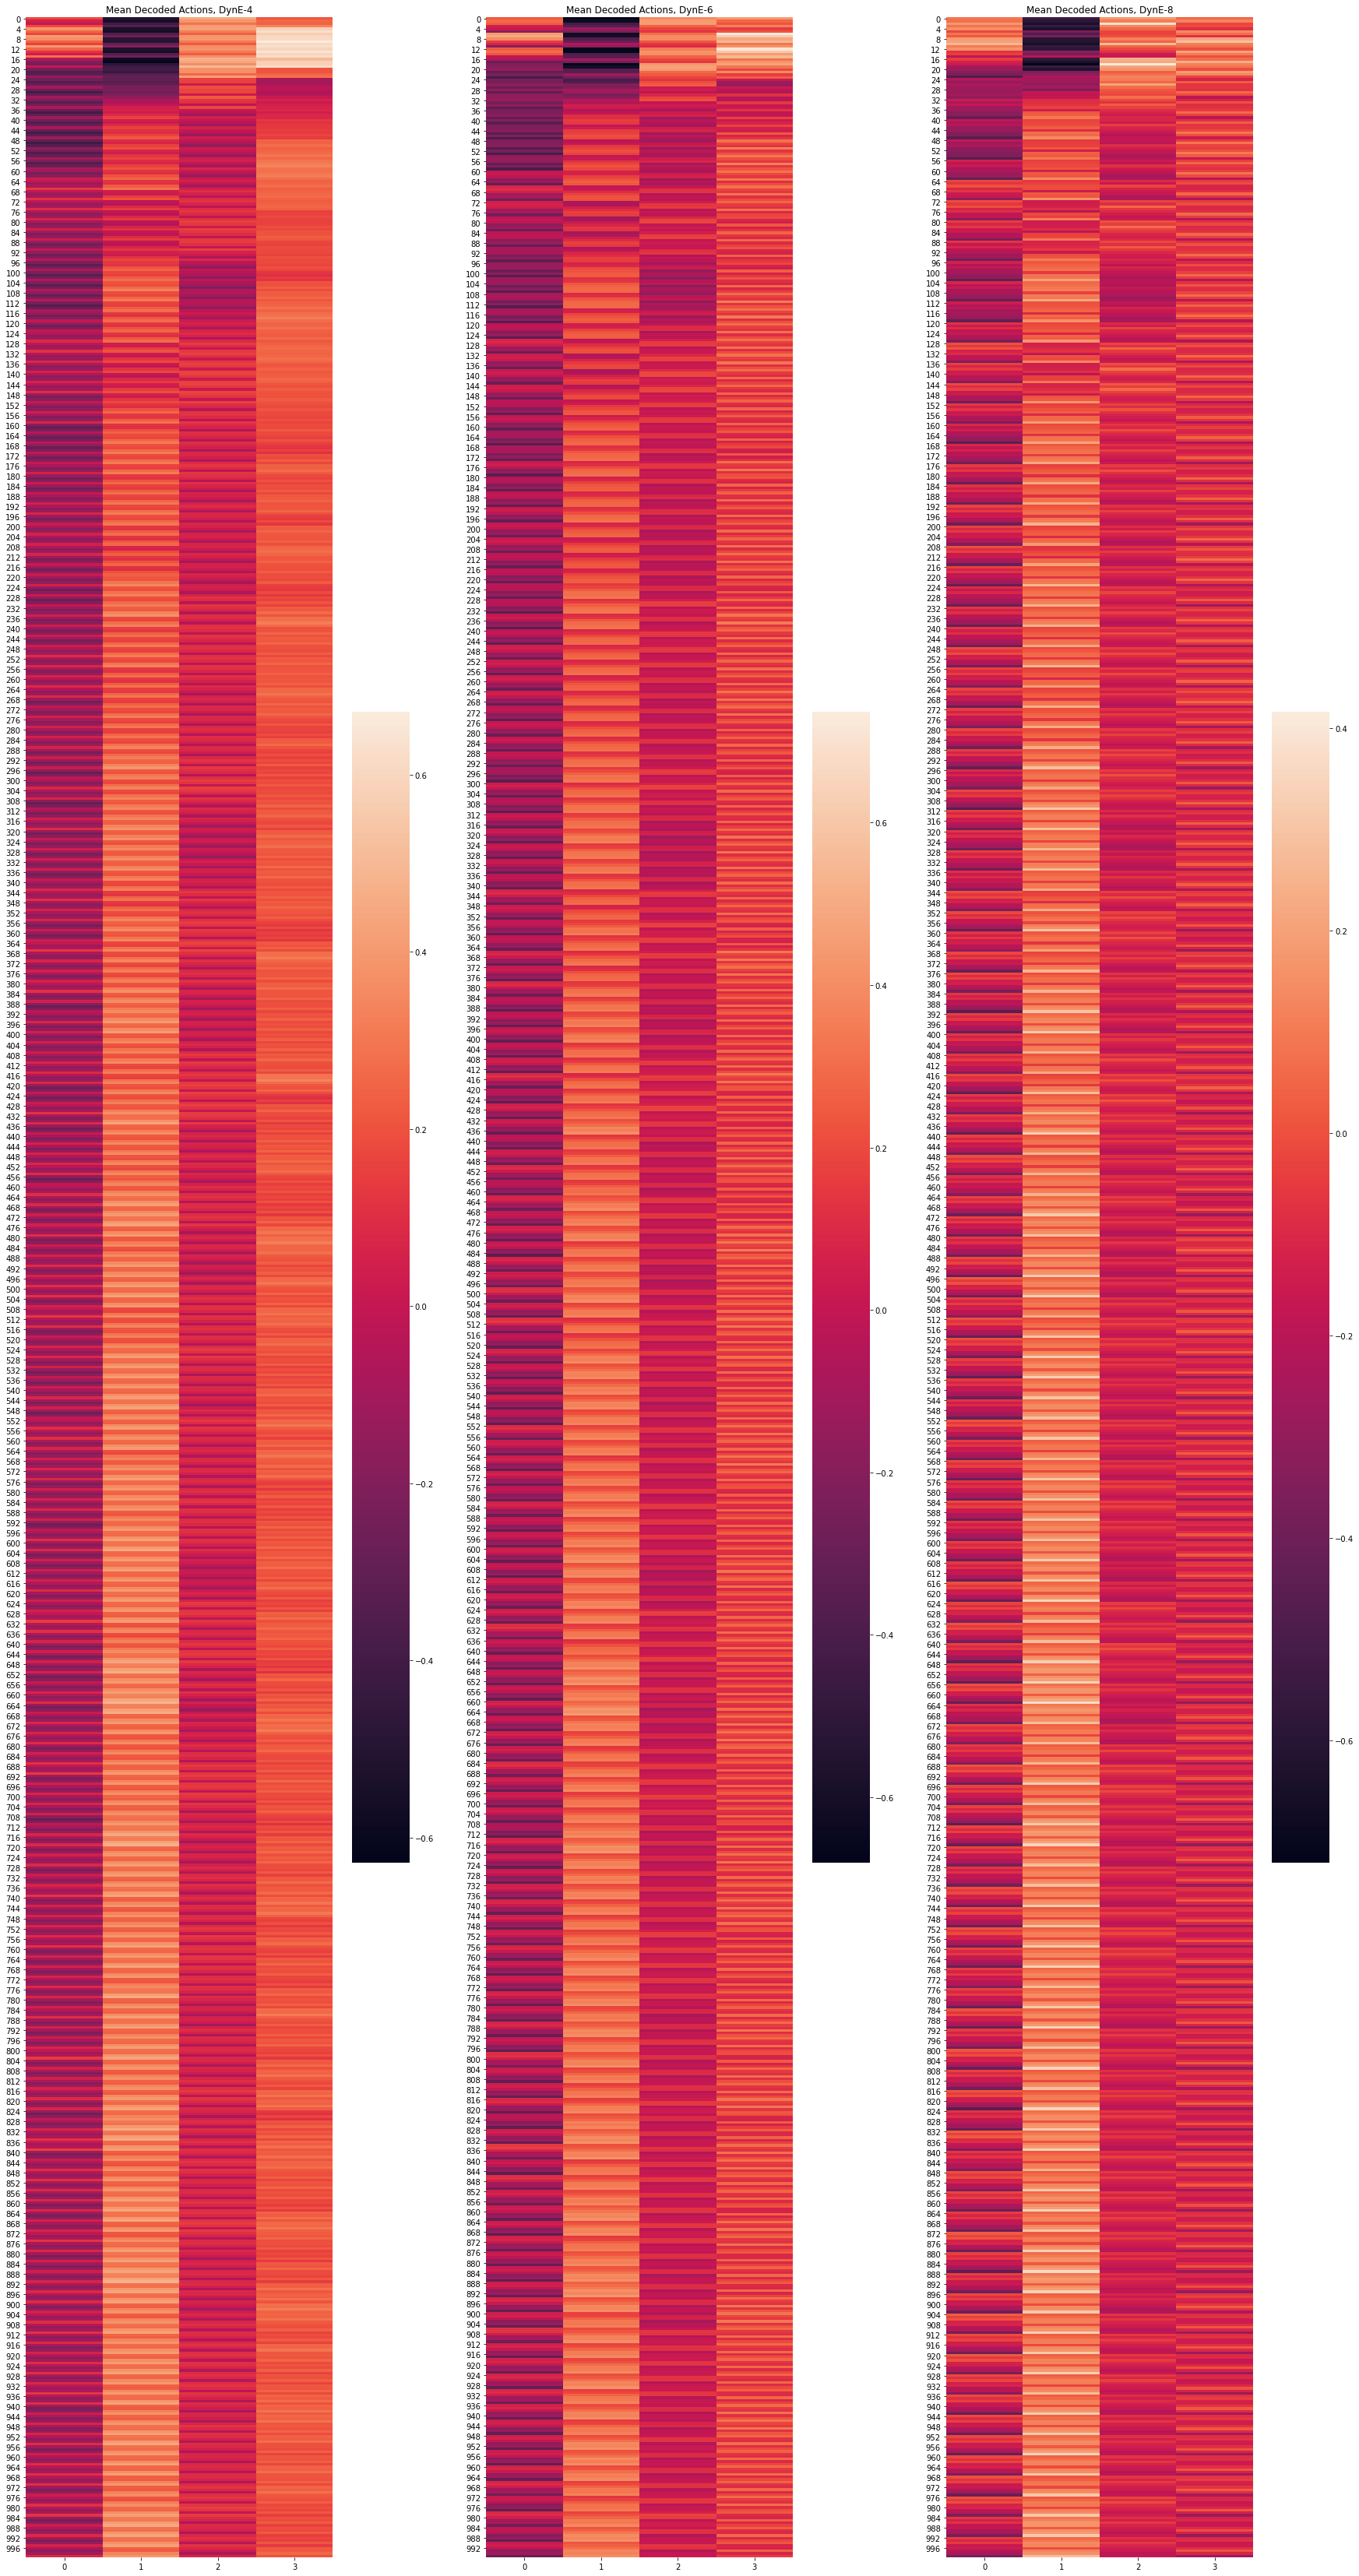

In [50]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 60), sharey=False)

x = sns.heatmap(dec_actions[4].mean(axis=0), ax=ax1)
ax1.set_title('Mean Decoded Actions, DynE-4')
y = sns.heatmap(dec_actions[6].mean(axis=0), ax=ax2)
ax2.set_title('Mean Decoded Actions, DynE-6')
x = sns.heatmap(dec_actions[8].mean(axis=0), ax=ax3)
ax3.set_title('Mean Decoded Actions, DynE-8')
wandb.log({'Mean decoded Actions, hopper_hop': wandb.Image(plt)})

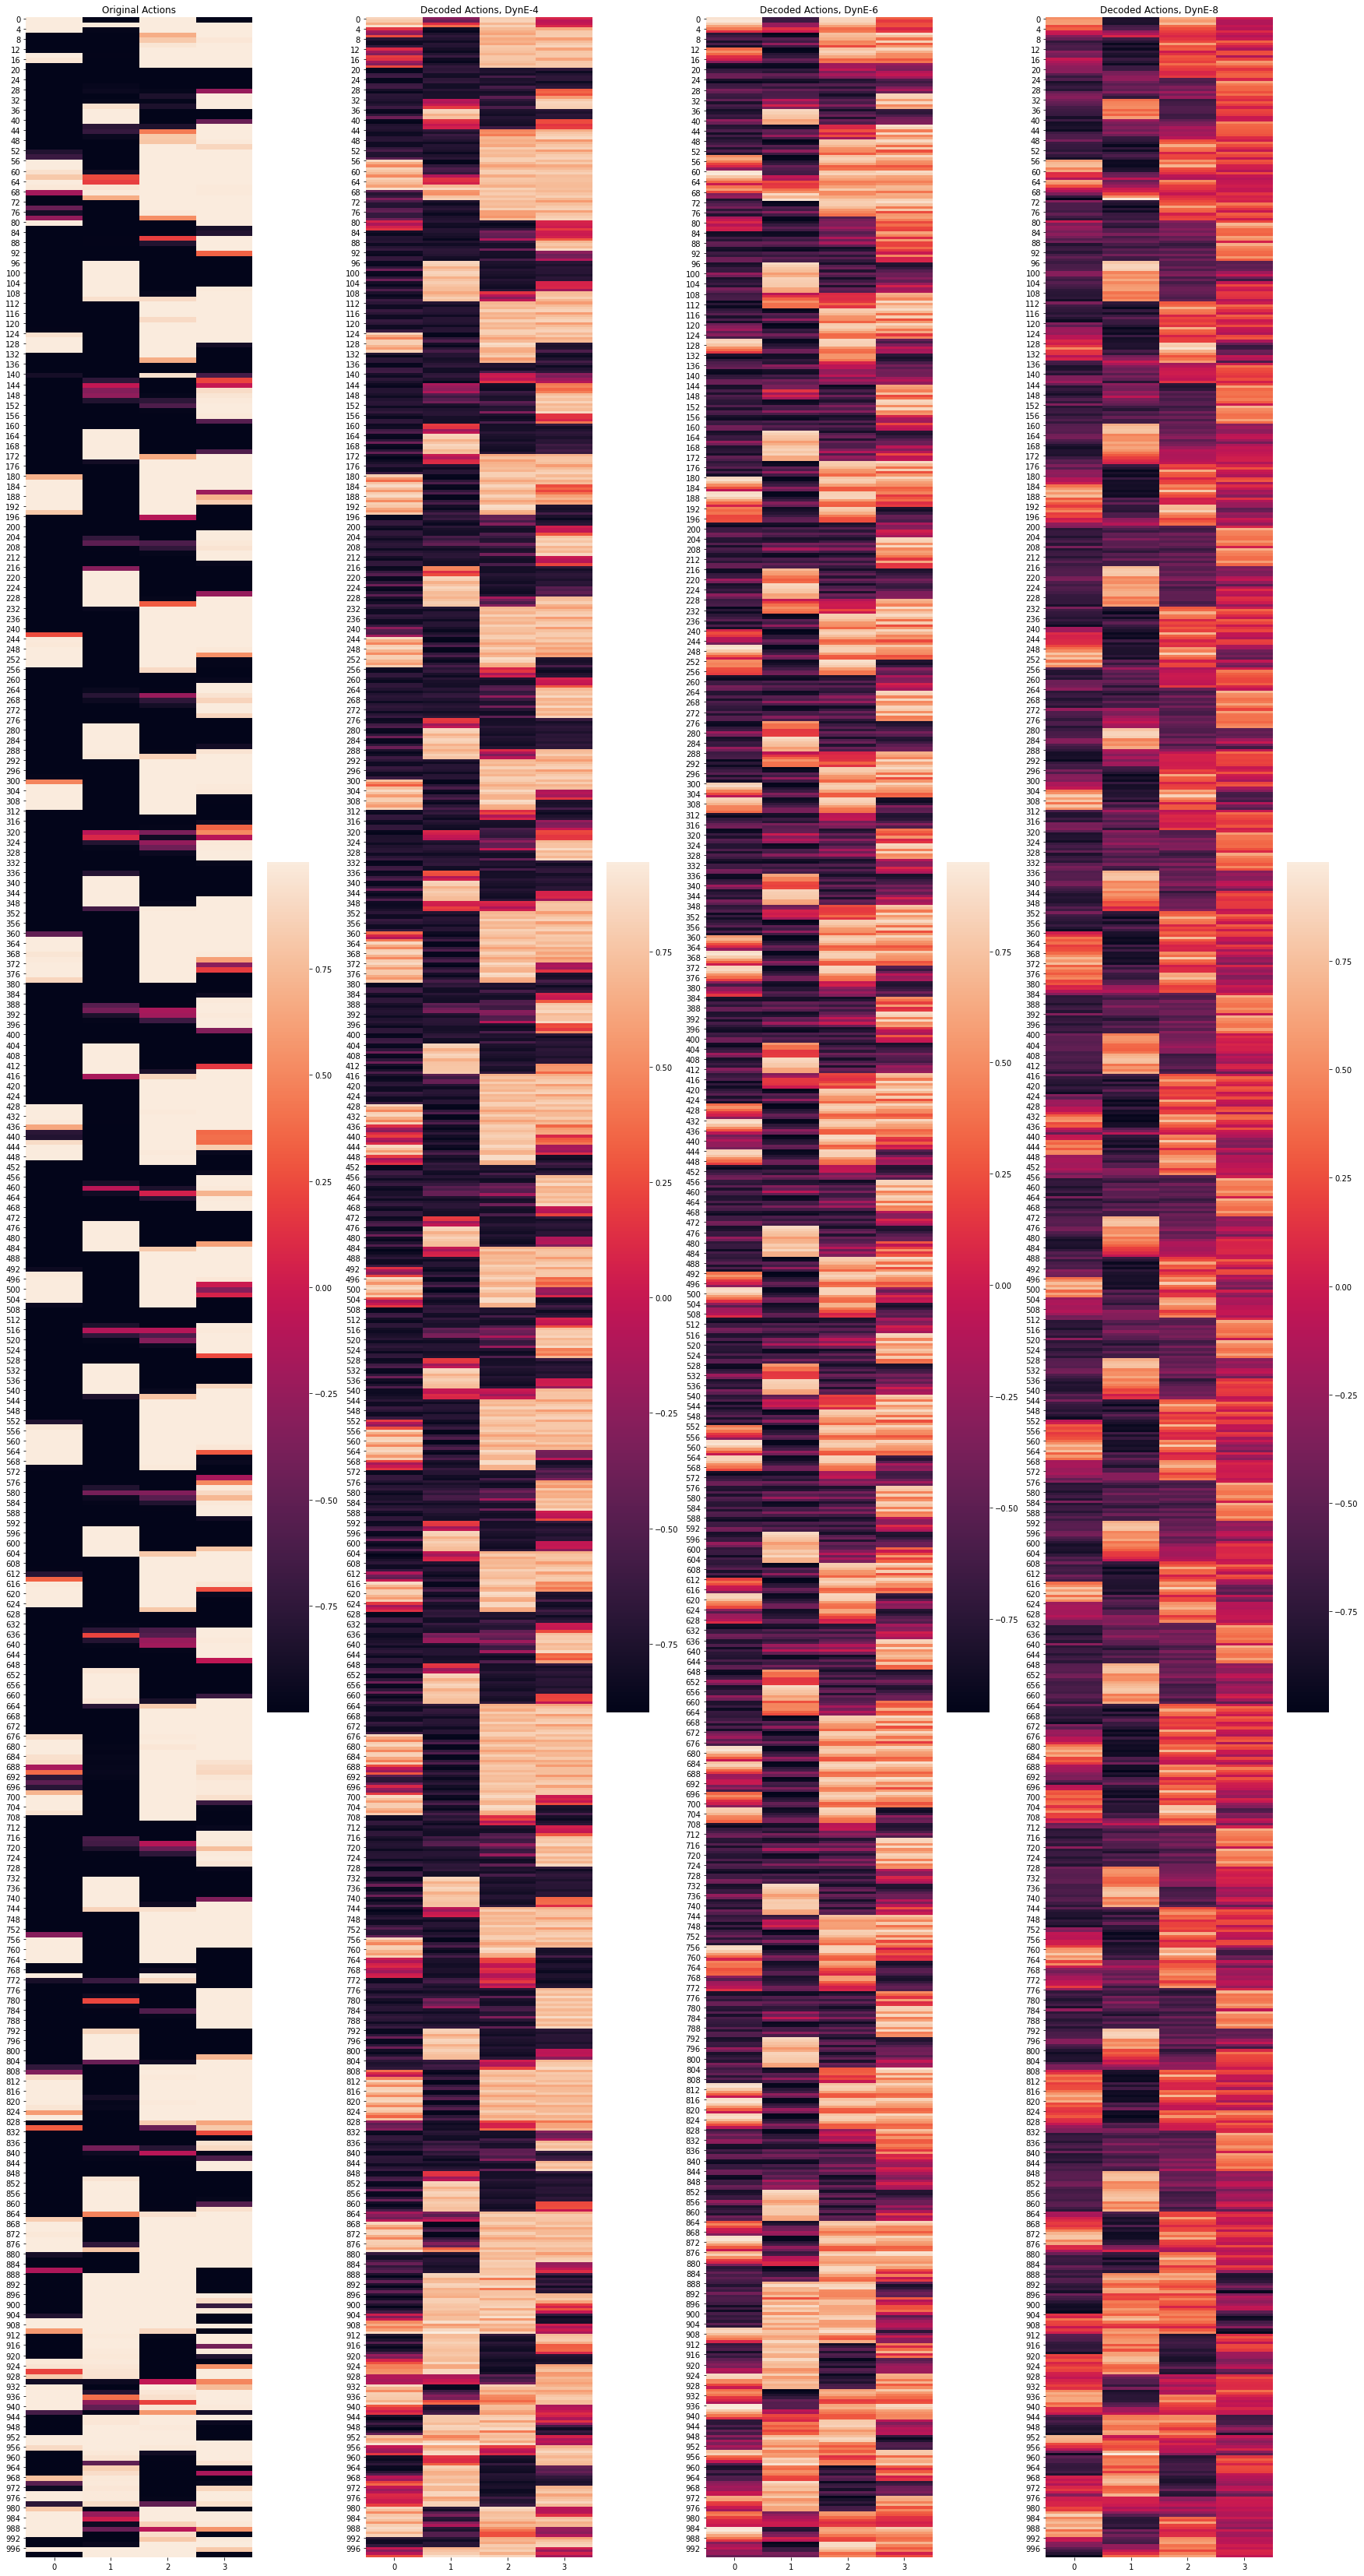

In [49]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 60), sharey=False)

x = sns.heatmap(actions[4][1], ax=ax1)
ax1.set_title('Original Actions')

y = sns.heatmap(dec_actions[4][1], ax=ax2)
ax2.set_title('Decoded Actions, DynE-4')

z = sns.heatmap(dec_actions[6][1], ax=ax3)
ax3.set_title('Decoded Actions, DynE-6')

w = sns.heatmap(dec_actions[8][1], ax=ax4)
ax4.set_title('Decoded Actions, DynE-8')


wandb.log({'Original vs Decoded actions, hopper_hop': wandb.Image(plt)})